In [ ]:
# libraries
#%matplotlib notebook
import plotly.express as px
import pandas as pd
import numpy as np
import warnings
import itertools
import seaborn
import matplotlib.dates as nd
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn. ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
df = pd.read_csv("DATOS_COMPLETOS.CSV", delimiter= ';', parse_dates=['DateObserved'])

In [ ]:
df.head(10)

,Id,Machine,DateStr,DateObserved,H,V,C
0,921880,Batidora,01/09/2018 13:39:16,2018-09-01 13:39:16,0.18,0.14,0.1
1,921881,Batidora,01/09/2018 13:39:46,2018-09-01 13:39:46,0.17,0.15,0.1
2,921882,Batidora,01/09/2018 13:40:15,2018-09-01 13:40:15,0.17,0.17,0.1
3,921883,Batidora,01/09/2018 13:42:56,2018-09-01 13:42:56,0.17,0.16,0.1
4,921884,Batidora,01/09/2018 13:43:26,2018-09-01 13:43:26,0.17,0.19,0.1
5,921885,Batidora,01/09/2018 13:43:56,2018-09-01 13:43:56,0.20,0.18,0.1
6,921886,Batidora,01/09/2018 13:44:26,2018-09-01 13:44:26,0.18,0.17,0.1
7,921887,Batidora,01/09/2018 13:44:55,2018-09-01 13:44:55,0.18,0.17,0.1
8,921888,Batidora,01/09/2018 13:45:25,2018-09-01 13:45:25,0.22,0.16,0.1
9,921889,Batidora,01/09/2018 13:45:55,2018-09-01 13:45:55,0.18,0.16,0.1


Selecciono los datos de la batidora y elimino las columnas innecesarias

In [ ]:
batidora = df.loc[df['Machine']== 'Batidora']
cols= ['Id', 'DateStr', 'Machine']
batidora.drop(cols, axis=1, inplace=True)
#batidora = batidora.sort_values('DateObserved')

Compruebo los datos que son nulos

In [ ]:
batidora.isnull().sum()

DateObserved     0
H               19
V                0
C                4
dtype: int64

In [ ]:
import plotly.express as px
df = batidora
df.head()

,DateObserved,H,V,C
0,2018-09-01 13:39:16,0.18,0.14,0.1
1,2018-09-01 13:39:46,0.17,0.15,0.1
2,2018-09-01 13:40:15,0.17,0.17,0.1
3,2018-09-01 13:42:56,0.17,0.16,0.1
4,2018-09-01 13:43:26,0.17,0.19,0.1


In [ ]:
fig= px.line(df[:500], x="DateObserved", y=df.columns,
             hover_data={"DateObserved": "|%c"},
             title='custom tick labels')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

Agrupo el dataset en grupos de 15 minutos donde aplico la media, después de agrupar pongo los nulos a la media.

In [ ]:
batidora= batidora.set_index('DateObserved')
batidora_resample15m = batidora.resample('15min').mean()
batidora_resample15m['H'].fillna(batidora_resample15m['H'].min(),inplace=True)
batidora_resample15m['C'].fillna(batidora_resample15m['C'].min(),inplace=True)
batidora_resample15m['V'].fillna(batidora_resample15m['V'].min(),inplace=True)
batidora_resample15m.head()

,H,V,C
DateObserved,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000
2018-09-01 13:45:00,0.181667,0.169000,0.100000
2018-09-01 14:00:00,0.183871,0.166452,0.100323
2018-09-01 14:15:00,0.190323,0.170968,0.102581
2018-09-01 14:30:00,0.195806,0.183871,0.100000


Creo otro dataset agrupado por 5 minutos para poder comparar

In [ ]:
batidora_resample5m = batidora.resample('5min').mean()
batidora_resample5m['H'].fillna(batidora_resample5m['H'].min(),inplace=True)
batidora_resample5m['C'].fillna(batidora_resample5m['C'].min(),inplace=True)
batidora_resample5m['V'].fillna(batidora_resample5m['V'].min(),inplace=True)
batidora_resample5m.head()

,H,V,C
DateObserved,,,
2018-09-01 13:35:00,0.175000,0.145000,0.1
2018-09-01 13:40:00,0.178333,0.173333,0.1
2018-09-01 13:45:00,0.185000,0.162000,0.1
2018-09-01 13:50:00,0.178000,0.174000,0.1
2018-09-01 13:55:00,0.182000,0.171000,0.1


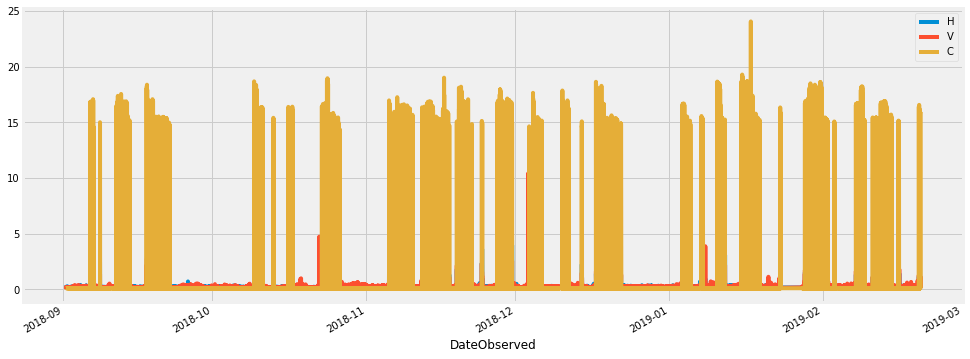

In [ ]:
batidora.plot(figsize=(15,6))
plt.show()

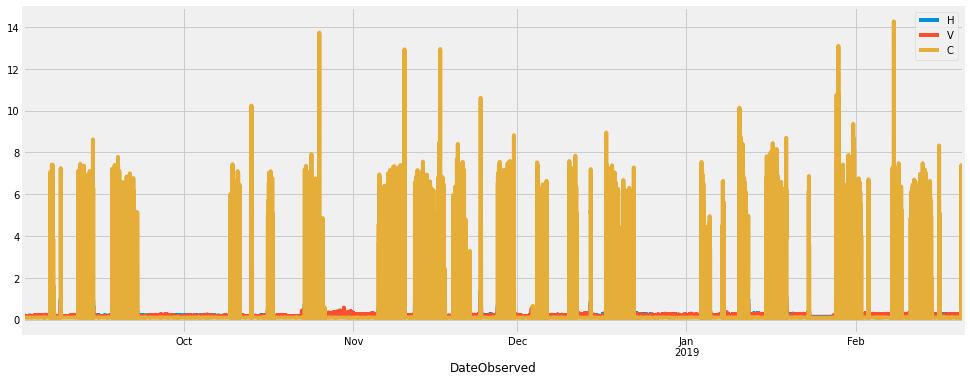

In [ ]:
batidora_resample15m.plot(figsize=(15,6))
plt.show()

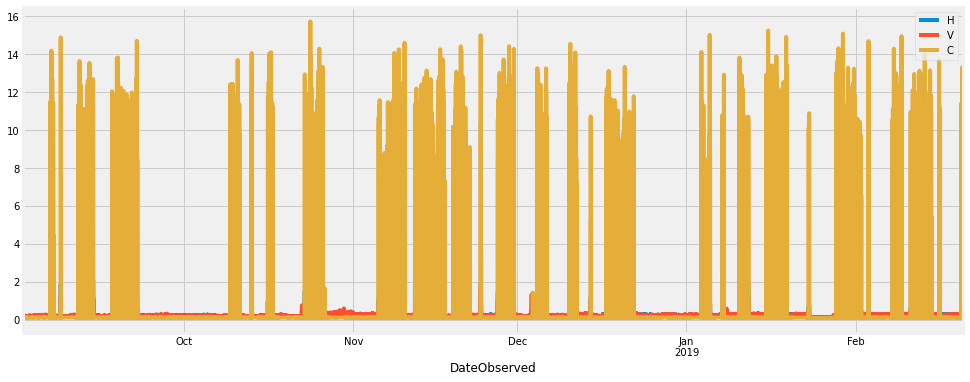

In [ ]:
batidora_resample5m.plot(figsize=(15,6))
plt.show()

## Clustering-Based Anomaly Detection

**k-means algorithm**

k-means es un algoritmo de clustering ampliamente utilizado. Crea "k" grupos similares de puntos de datos. Las instancias de datos que caen fuera de estos grupos podrían marcarse como anomalías. Antes de comenzar con la agrupación de k-means, usamos el método de la **curva de Elbow** determinar el número óptimo de agrupaciones.

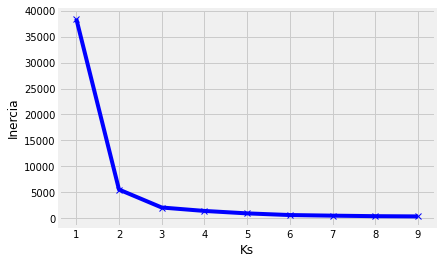

In [ ]:
#Vamos la inertia con kmeans para distintos números de clusters:
data = batidora_resample15m[['H', 'V', 'C']]
from sklearn.cluster import KMeans
inercias=[]
for k in range(1,10):
  kmeans=KMeans(n_clusters=k)
  kmeans.fit(data)
  inercias.append(kmeans.inertia_)

plt.plot(range(1, 10), inercias, 'bx-')
plt.xlabel('Ks')
plt.ylabel('Inercia')
plt.show()

De la curva del Elbow, vemos que la gráfica se nivela después de 4 grupos, lo que implica que la adición de más grupos no explica mucho más la varianza en nuestra variable relevante

El siguiente paso es predecir y representar los clusters con sus centroides

In [ ]:
X = batidora_resample15m[['H', 'V', 'C']]
#X = X.reset_index(drop=True)
km = KMeans(n_clusters=4)
km.fit(X)
y_kmeans=km.predict(X)
labels = km.labels_

Representación 2D

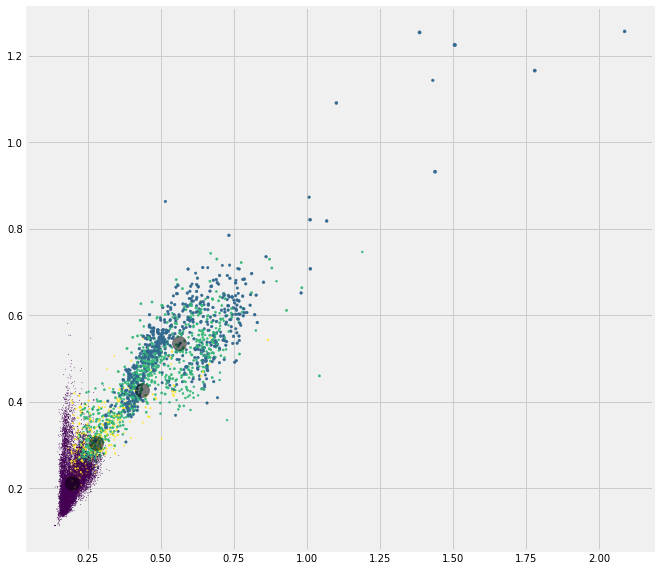

In [ ]:
#ploting 2D
fig= plt.figure(1, figsize=(10,10))
colors = ['r', 'g', 'b', 'y', 'c', 'm']
#fig, ax = plt.subplots()
#ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:2], c=labels.astype(np.float), edgecolor="k")

plt.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_kmeans)

centers =km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5);

Vemos que hay 3 centroides y los clusters coloreados con diferentes colores pero se superponen unos con otros, por lo que no tenemos una vision clara, asi que lo visualizamos en 3D para verlo mejor.

Representación 3D

No handles with labels found to put in legend.


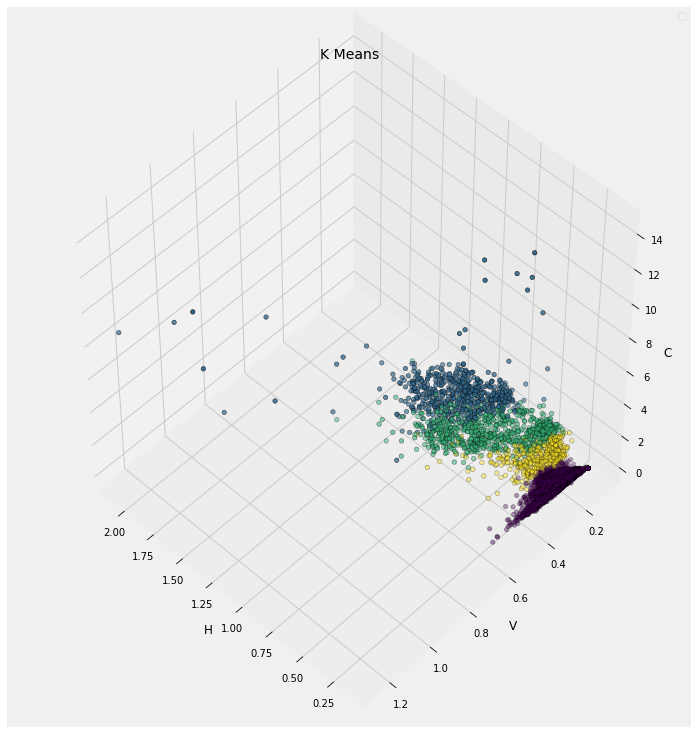

In [ ]:
#Plotting
fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:, 1], X.iloc[:,2],
           c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("H")
ax.set_ylabel("V")
ax.set_zlabel("C")
plt.legend()
plt.title("K Means", fontsize=14);


Clasifico los datos en los diferentes clusters

In [ ]:
data = X[['H', 'V', 'C']]
resultado = X
kmeans = KMeans(n_clusters=4).fit(data)
center = kmeans.cluster_centers_
resultado['cluster'] = kmeans.predict(data)
resultado['DateObserved'] = X.index
resultado.index = data.index
resultado['cluster'].value_counts()

0    14552
1      914
2      604
3      452
Name: cluster, dtype: int64

En esta sección de código creo una función que mide la distancia de los puntos en base a su centroide. La distancia se calcula

In [ ]:
resultado.head()

,H,V,C,cluster,DateObserved
DateObserved,,,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000,0,2018-09-01 13:30:00
2018-09-01 13:45:00,0.181667,0.169000,0.100000,0,2018-09-01 13:45:00
2018-09-01 14:00:00,0.183871,0.166452,0.100323,0,2018-09-01 14:00:00
2018-09-01 14:15:00,0.190323,0.170968,0.102581,0,2018-09-01 14:15:00
2018-09-01 14:30:00,0.195806,0.183871,0.100000,0,2018-09-01 14:30:00


In [ ]:
#Las distancias del primer centroide
kmeans.transform(data)

array([[0.05016943, 3.8377453 , 6.58857213, 1.92855488],
       [0.04614851, 3.83728115, 6.58817708, 1.9281479 ],
       [0.04793719, 3.83698596, 6.58787045, 1.92789853],
       ...,
       [3.29072123, 0.5720003 , 3.29822962, 1.37024597],
       [0.06154024, 3.82673635, 6.5785482 , 1.91973989],
       [2.56882562, 1.26333195, 4.01517149, 0.65051772]])

In [ ]:
outliers_fraction = 0.01
#Obtengo el mínimo del número de regristros obtenido al calcular el numero de outliers
#las distancias se ordenan de mayor a menory se cogen los x numero de outlier
distances = (kmeans.transform(data))
#anomaly1 contain the anomaly result of the above method Cluster (0:anomalia, 1:normal)
resultado['distance'] = kmeans.transform(data)[:,0]
resultado['anomaly1'] = (resultado['distance']>= outliers_fraction).astype(int)
resultado.head(10)

,H,V,C,cluster,DateObserved,distance,anomaly1
DateObserved,,,,,,,
2018-09-01 13:30:00,0.177500,0.166250,0.100000,0,2018-09-01 13:30:00,0.050169,1
2018-09-01 13:45:00,0.181667,0.169000,0.100000,0,2018-09-01 13:45:00,0.046149,1
2018-09-01 14:00:00,0.183871,0.166452,0.100323,0,2018-09-01 14:00:00,0.047937,1
2018-09-01 14:15:00,0.190323,0.170968,0.102581,0,2018-09-01 14:15:00,0.042170,1
2018-09-01 14:30:00,0.195806,0.183871,0.100000,0,2018-09-01 14:30:00,0.028929,1
2018-09-01 14:45:00,0.199667,0.175000,0.100000,0,2018-09-01 14:45:00,0.037925,1
2018-09-01 15:00:00,0.190645,0.177742,0.100000,0,2018-09-01 15:00:00,0.035492,1
2018-09-01 15:15:00,0.183548,0.173548,0.100000,0,2018-09-01 15:15:00,0.041246,1
2018-09-01 15:30:00,0.185161,0.174839,0.100000,0,2018-09-01 15:30:00,0.039538,1


In [ ]:
resultado['anomaly1'].value_counts()

1    16078
0      444
Name: anomaly1, dtype: int64

Tenemos un 2,3% de anomalias en los datos

In [ ]:
scaler= MinMaxScaler(feature_range=(0,1))
resultado['probality']=scaler.fit_transform(resultado[['distance']])*100
resultado['level']='low'
resultado['level']=np.where(resultado['probality']>=50, 'medium', 'low')
resultado['level']=np.where(resultado['probality']>=60, 'high', resultado['level'])
resultado['level']=np.where(resultado['probality']>=75, 'critical', resultado['level'])
resultado['level'].value_counts()

low         16399
medium         99
high           15
critical        9
Name: level, dtype: int64

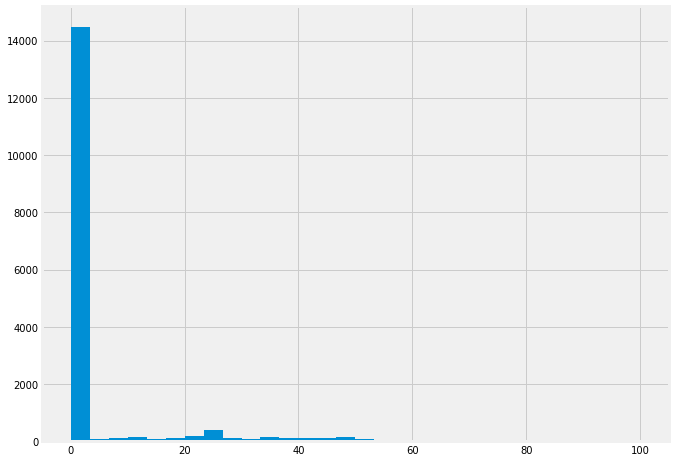

In [ ]:
resultado['probality'].hist(bins=30, grid=True, figsize=(10,8))

In [ ]:
resultado['probality'].describe(percentiles=(.1,.25,.5,.75,.9,.95,0.99))

count    16522.000000
mean         3.902451
std         10.646869
min          0.000000
10%          0.117878
25%          0.204358
50%          0.335778
75%          0.544778
90%         16.327796
95%         30.110277
99%         48.940222
max        100.000000
Name: probality, dtype: float64

count     21.000000
mean      76.306372
std       12.887649
min       61.010219
10%       61.522429
25%       63.889251
50%       74.674673
75%       90.625643
90%       91.725410
95%       96.217499
99%       99.243500
max      100.000000
Name: probality, dtype: float64

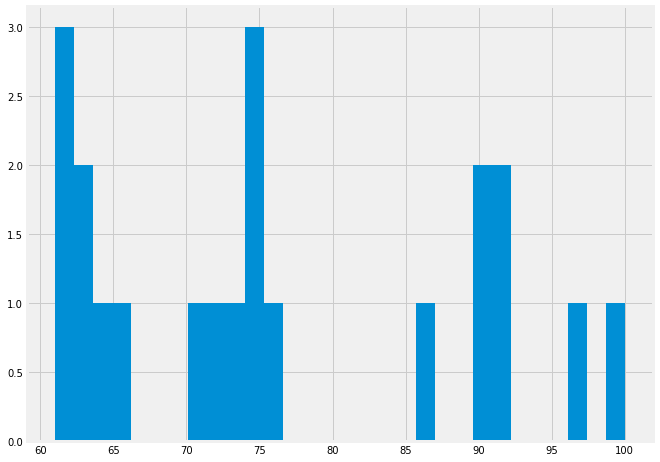

In [ ]:
criticas_altas =resultado.loc[(resultado['anomaly1']==1) & (resultado['probality'] >=61)]
criticas_altas['probality'].hist(bins=30, grid=True, figsize=(10,8))
criticas_altas['probality'].describe(percentiles=(.1,.25,.5,.75,.9,.95,0.99))

## Pintar anomalias

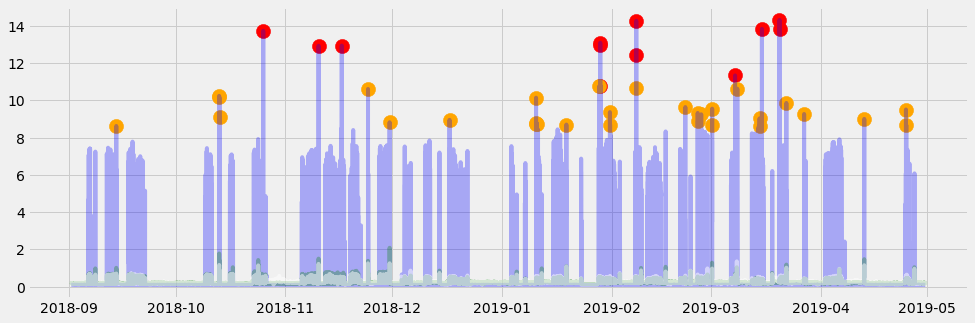

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

criticas =resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='high')]
ax.scatter(criticas['DateObserved'], criticas['C'], color='red', s=200)
ax.scatter(altas['DateObserved'], altas['C'], color='orange', s=200)
ax.plot(resultado['DateObserved'], resultado['C'], color='blue', alpha=0.3)
ax.plot(resultado['DateObserved'], resultado['H'], color='green', alpha=0.3)
ax.plot(resultado['DateObserved'], resultado['V'], color='white', alpha=0.5)
plt.show()

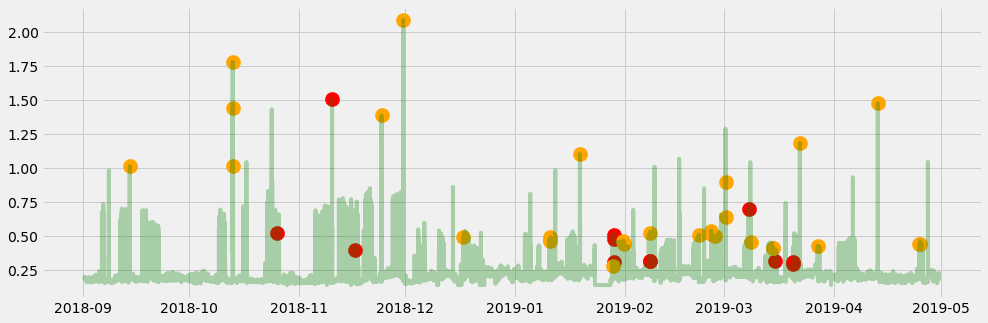

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

criticas =resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='high')]
ax.scatter(criticas['DateObserved'], criticas['H'], color='red', s=200)
ax.scatter(altas['DateObserved'], altas['H'], color='orange', s=200)
ax.plot(resultado['DateObserved'], resultado['H'], color='green', alpha=0.3)
plt.show()

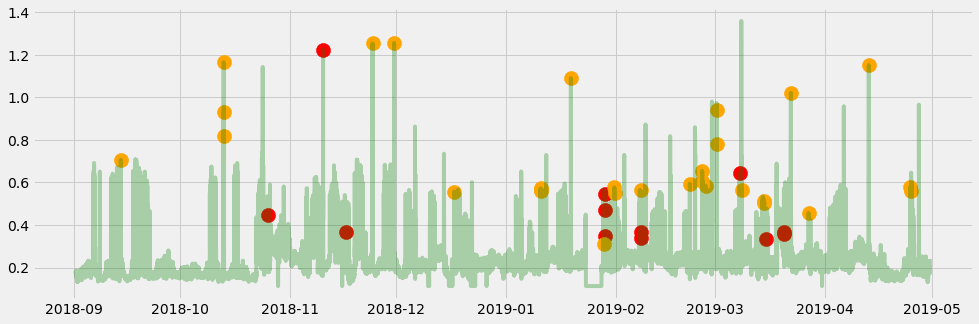

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

criticas =resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='critical')]
altas = resultado.loc[(resultado['anomaly1']==1) & (resultado['level'] =='high')]
ax.scatter(criticas['DateObserved'], criticas['V'], color='red', s=200)
ax.scatter(altas['DateObserved'], altas['V'], color='orange', s=200)
ax.plot(resultado['DateObserved'], resultado['V'], color='green', alpha=0.3)
plt.show()

En estas gráficas observamos los puntos rojos como las anomalias críticas y en naranja las anomalias altas.

In [ ]:
importantes=resultado.loc[(resultado['anomaly1']==1)&(resultado['probality']>=60)]
importantes.head(20)

,H,V,C,cluster,DateObserved,distance,anomaly1,probality,level
DateObserved,,,,,,,,,
2018-09-14 07:00:00,1.012258,0.707097,8.626774,1,2018-09-14 07:00:00,8.577205,1,60.328249,high
2018-10-13 07:30:00,1.780000,1.165484,10.243226,1,2018-10-13 07:30:00,10.307149,1,72.497763,high
2018-10-13 08:30:00,1.439000,0.931667,10.160000,1,2018-10-13 08:30:00,10.159021,1,71.455739,high
2018-10-13 10:00:00,1.011290,0.820645,9.100000,1,2018-10-13 10:00:00,9.054448,1,63.685475,high
2018-10-25 18:00:00,0.525000,0.446000,13.732333,1,2018-10-25 18:00:00,13.635895,1,95.914263,critical
2018-11-10 08:30:00,1.506452,1.224839,12.930645,1,2018-11-10 08:30:00,12.934132,1,90.977624,critical
2018-11-16 21:30:00,0.393437,0.369375,12.943437,1,2018-11-16 21:30:00,12.843557,1,90.340461,critical
2018-11-24 07:15:00,1.385938,1.253750,10.612813,1,2018-11-24 07:15:00,10.628008,1,74.754887,high
2018-11-30 09:30:00,2.087742,1.256129,8.825484,1,2018-11-30 09:30:00,8.985570,1,63.200945,high


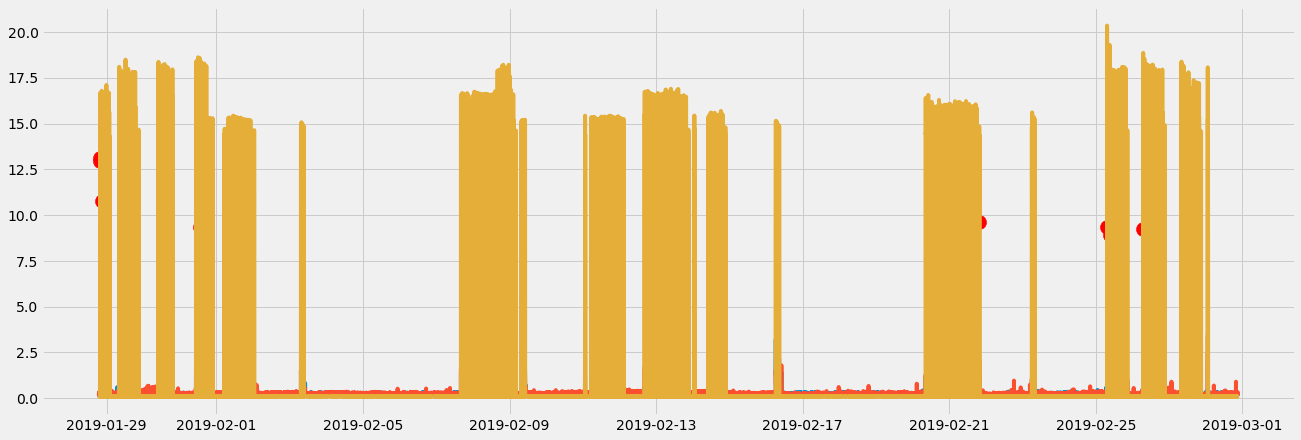

In [ ]:
dfsub=batidora.loc['2019-01-28 19':'2019-02-28 20']
anomalias= importantes.loc['2019-01-28 19':'2019-02-28 20']
fig, ax=plt.subplots(figsize=(20,7))
x=dfsub.index
ax.scatter(anomalias['DateObserved'], anomalias['C'], color='red', s=200)
ax.plot(x,dfsub['H'])
ax.plot(x,dfsub['V'])
ax.plot(x,dfsub['C'])
plt.show()